In [1]:
from clevar import ClCatalog, MemCatalog

In [2]:
import clevar

In [3]:
clevar.__version__

'0.10.3'

In [2]:
import GCRCatalogs
from cluster_validation.opening_catalogs_functions import *
from matplotlib import pyplot as plt
import matplotlib 

matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'figure.figsize': (10,8)})

# 0 - opening catalogs

In [3]:
min_richness = 5
min_halo_mass = 1e13 #Msun

In [4]:
RM_cat = ClCatalog.read('RM_cat_richness_min_'+str(min_richness)+'.fits', id='id', ra='ra', dec='dec', z='z', mass='mass')

In [5]:
#RM_cat_DC2 = ClCatalog.read('RM_cat_DR6_richness_min_'+str(min_richness)+'.fits', id='id', ra='ra', dec='dec', z='z', mass='mass')

In [6]:
halo_cat = ClCatalog.read('halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', id='id', ra='ra', dec='dec', z='z', mass='mass')

In [7]:
RM_cat.read_members('RM_cat_richness_min_'+str(min_richness)+'_members.fits',  id='id',  id_cluster='id_cluster', ra='ra', dec='dec', redshift='redshift', pmem='pmem' )

In [8]:
#RM_cat_DC2.read_members('RM_cat_DR6_richness_min_'+str(min_richness)+'_members.fits',  id='id',  id_cluster='id_cluster', ra='ra', dec='dec', redshift='redshift', pmem='pmem' )

In [9]:
halo_cat.read_members('halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', id='id',  id_cluster='id_cluster', ra='ra', dec='dec', redshift='redshift')

# 2 - associate redMaPPer detections to true DC2 halos

In [10]:
RM_cat._init_match_vals(True)
halo_cat._init_match_vals(True)

In [ ]:
from clevar.match import MembershipMatch

In [11]:
mt = MembershipMatch()

In [12]:
match_config = {
    'type': 'cross', # options are cross, cat1, cat2
    'preference': 'shared_member_fraction', # other options are more_massive, angular_proximity or redshift_proximity
    'minimum_share_fraction': 0,
    'match_members_kwargs': {'method':'id'},
}

In [13]:
mt.match_from_config(RM_cat, halo_cat, match_config)


## Multiple match (catalog 1)
Finding candidates (cosmoDC2_v1.1.4_redmapper_v0.8.1)
* 43,211/45,081 objects matched.

## Multiple match (catalog 2)
Finding candidates (cosmoDC2_v1.1.4_image)
* 75,514/278,904 objects matched.

## Finding unique matches of catalog 1
Unique Matches (cosmoDC2_v1.1.4_redmapper_v0.8.1)
* 43,211/45,081 objects matched.

## Finding unique matches of catalog 2
Unique Matches (cosmoDC2_v1.1.4_image)
* 75,514/278,904 objects matched.
Cross Matches (cosmoDC2_v1.1.4_redmapper_v0.8.1)
* 42,754/45,081 objects matched.
Cross Matches (cosmoDC2_v1.1.4_image)
* 42,827/278,904 objects matched.


In [14]:
mt.save_matches(RM_cat, halo_cat, out_dir='cosmoDC2_RM_match_cross_membership', overwrite=True)

In [15]:
mt.load_matches(RM_cat, halo_cat, out_dir='cosmoDC2_RM_match_cross_membership')
display(RM_cat)
display(halo_cat)

cosmoDC2_v1.1.4_redmapper_v0.8.1
 * Total objects:    45,081
 * multiple (self):  43,211
 * multiple (other): 43,211
 * unique (self):    43,211
 * unique (other):   42,825
 * cross:            42,754

cosmoDC2_v1.1.4_image
 * Total objects:    278,904
 * multiple (self):  75,514
 * multiple (other): 75,514
 * unique (self):    75,514
 * unique (other):   42,973
 * cross:            42,827


# bijective association

In [16]:
from clevar.match import get_matched_pairs

In [153]:
import clevar.match

In [17]:
mt1, mt2 = get_matched_pairs(RM_cat, halo_cat, 'cross')

Text(0, 0.5, 'halo mass')

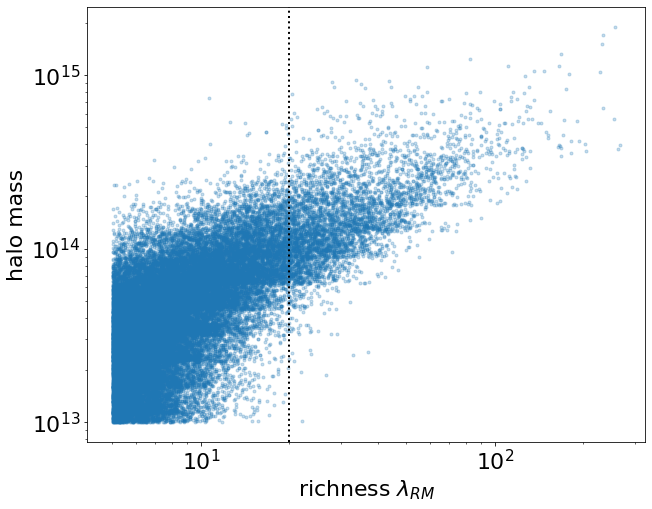

In [21]:
plt.loglog(mt1['mass'], mt2['mass'], '.',alpha=0.25)
plt.axvline(20, color='black', linestyle='dotted', lw=2)

plt.xlabel("richness $\\lambda_{RM}$")
plt.ylabel('halo mass')

# overmerging and fragmentation

In [336]:
def frac_2d_clevar(cat, mt, multiplicity, extra_cond=None, bin_range = None, bins = None, nmin=10) :
    
    hist_num_match = np.histogram2d(mt['z'], np.log10(mt['mass']),range=bin_range, bins= bins)
    number_of_match = hist_num_match[0]
    
    condm = (multiplicity>1)
    cond = condm
    
    if isinstance(extra_cond, type(np.ndarray)):
        print("extra cond")
        cond = condm * extra_cond

    hist_num_multiplicity = np.histogram2d(cat["z"][cond],np.log10(cat['mass'][cond]),range=bin_range, bins= bins)
    number_of_multiplicity = hist_num_multiplicity[0]
    
    #area_ratio = np.min([gc_truth.sky_area, gc.sky_area])/gc_truth.sky_area
    
    #compl_2d = 1/ area_ratio * number_of_match/number_of_halo
    frac_2d = number_of_multiplicity/number_of_match
        
    frac_2d_masked = np.ma.masked_where(number_of_match<nmin, frac_2d)
    
    return frac_2d, frac_2d_masked

In [254]:
multiplicity_RM = np.array([len(i) for i in RM_cat["mt_multi_self"]])

In [255]:
multiplicity_DC2 = np.array([len(i) for i in halo_cat["mt_multi_self"]])

Text(0.5, 0, 'RM multiplicity')

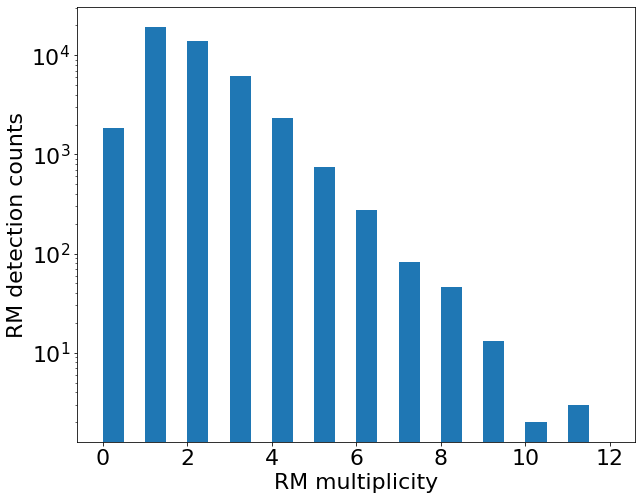

In [361]:
plt.hist(multiplicity_RM, bins=24, range=[0,12])
plt.yscale('log')


plt.ylabel('RM detection counts')
plt.xlabel('RM multiplicity')

Text(0.5, 0, 'halo multiplicity')

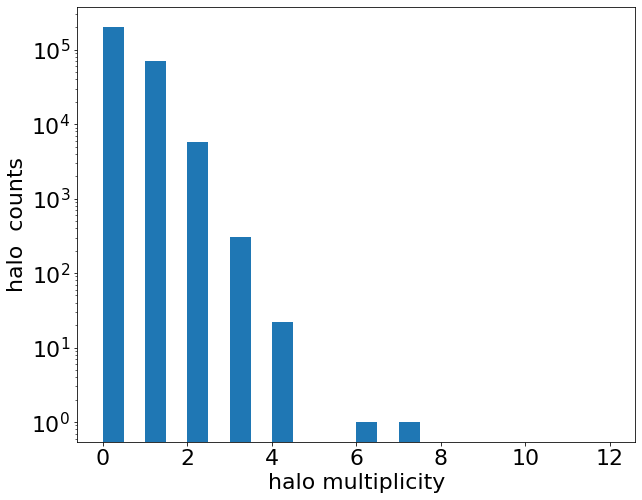

In [363]:
plt.hist(multiplicity_DC2, bins=24, range=[0,12])
plt.yscale('log')

plt.ylabel('halo  counts')
plt.xlabel('halo multiplicity')

In [364]:
#overmerging total fraction

multiplicity_RM[multiplicity_RM>1].size/mt1.size

0.5557608644805164

In [365]:
bin_range = [[0.,1.2],[0.7,2.2]]
bins = [12,15]

ovmg_2d, ovmg_2d_mask = frac_2d_clevar(RM_cat, mt1, multiplicity_RM, bin_range = bin_range, bins = bins, nmin=10) 

<ipython-input-336-c98672f965b4>:19: RuntimeWarning: invalid value encountered in true_divide
  frac_2d = number_of_multiplicity/number_of_match


Text(0.5, 1.0, 'overmerging fraction')

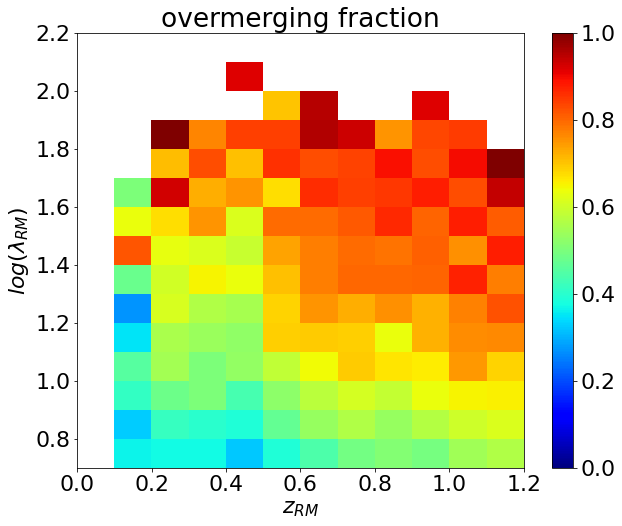

In [366]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(ovmg_2d_mask.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');
fig.colorbar(im , ax=ax);

ax.set_xlabel('$z_{RM}$')
ax.set_ylabel('$log(\lambda_{RM})$')

ax.set_title('overmerging fraction')

In [367]:
#fragmentation total fraction
multiplicity_DC2[multiplicity_DC2>1].size/mt1.size

0.1428170463582355

In [368]:
bin_range = [[0.1,1.3],[13.,14.8]]
bins = [12,18]

#cond_mt = mt1["mass"]>20

frag_2d, frag_2d_mask = frac_2d_clevar(halo_cat, mt2, multiplicity_DC2, bin_range = bin_range, bins = bins, nmin=10) 

<ipython-input-336-c98672f965b4>:19: RuntimeWarning: invalid value encountered in true_divide
  frac_2d = number_of_multiplicity/number_of_match


Text(0.5, 1.0, 'fragmentation fraction')

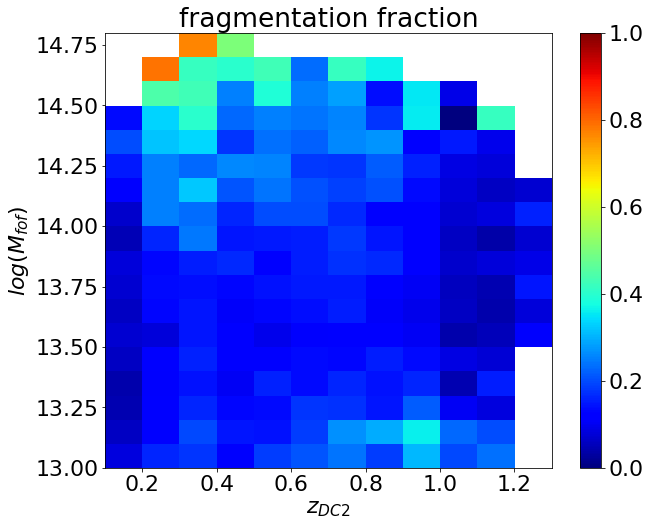

In [369]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(frag_2d_mask.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');
fig.colorbar(im , ax=ax);

ax.set_xlabel('$z_{DC2}$')
ax.set_ylabel('$log(M_{fof})$')

ax.set_title('fragmentation fraction')

# unmatched cases

In [370]:
RM_unmatched = np.where(RM_cat["mt_cross"]==None)[0]

In [371]:
len(RM_unmatched) 

2327

In [189]:
#RM_cat[RM_unmatched][RM_cat["mass"][RM_unmatched]>20]

In [187]:
RM_unmatched = np.where(RM_cat["mt_cross"]==None)[0]

In [188]:
len(RM_unmatched) 

2327

In [253]:
RM_cat[RM_unmatched][RM_cat["mass"][(RM_unmatched]>20)]

In [191]:
halo_unmatched = np.where(halo_cat["mt_cross"]==None)[0]

In [192]:
len(halo_unmatched) 

236077

In [198]:
halo_cat[halo_unmatched][halo_cat["mass"][halo_unmatched]>2e14]

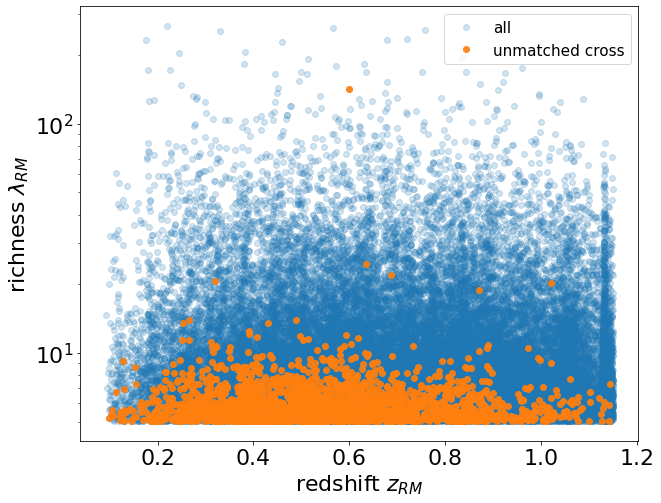

In [179]:
plt.plot(RM_cat['z'], RM_cat['mass'],'o',label="all", alpha=0.2)
plt.yscale('log')
plt.plot(RM_cat['z'][RM_unmatched], RM_cat['mass'][RM_unmatched],'o',label="unmatched cross", alpha=0.9)

plt.xlabel('redshift $z_{RM}$')
plt.ylabel('richness $\lambda_{RM}$')
plt.legend(fontsize='x-small')

Text(0, 0.5, 'dec')

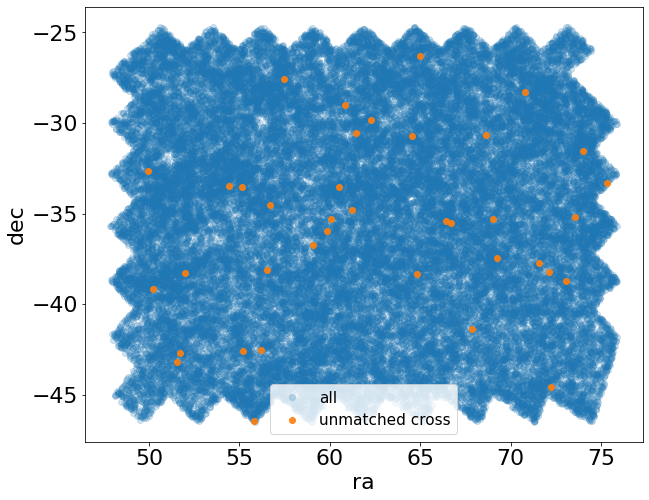

In [374]:
plt.plot(RM_cat['ra'], RM_cat['dec'],'o',label="all", alpha=0.2)
plt.plot(RM_cat['ra'][RM_unmatched][RM_cat["mass"][RM_unmatched]>10], RM_cat['dec'][RM_unmatched][RM_cat["mass"][RM_unmatched]>10],'o',label="unmatched cross", alpha=0.9)

plt.legend(fontsize='x-small')

plt.xlabel('ra')
plt.ylabel('dec')

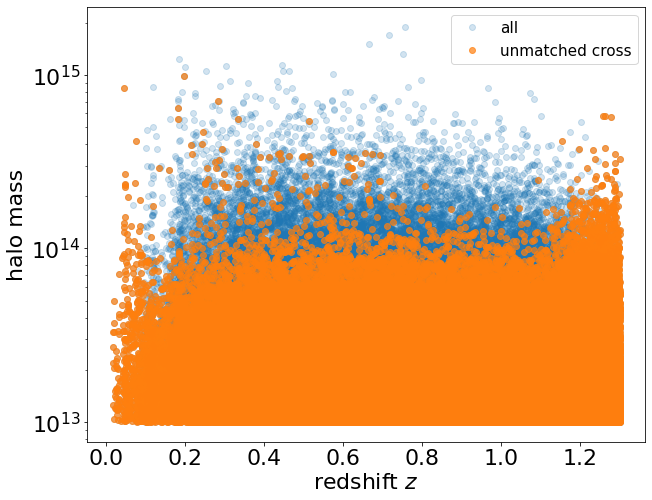

In [197]:
plt.plot(halo_cat['z'], halo_cat['mass'],'o',label="all", alpha=0.2)
plt.yscale('log')
plt.plot(halo_cat['z'][halo_unmatched], halo_cat['mass'][halo_unmatched],'o', label="unmatched cross", alpha=0.7)

plt.xlabel('redshift $z$')
plt.ylabel('halo mass')
plt.legend(fontsize='x-small')

Text(0, 0.5, 'dec')

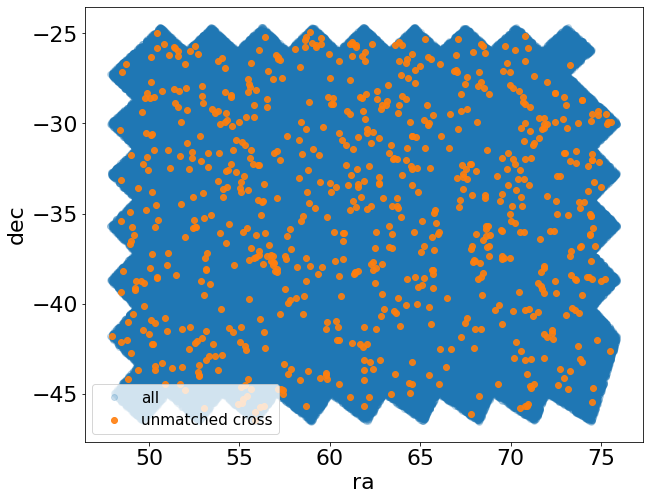

In [375]:
plt.plot(halo_cat['ra'], halo_cat['dec'],'o',label="all", alpha=0.2)
plt.plot(halo_cat['ra'][halo_unmatched][halo_cat["mass"][halo_unmatched]>1e14], halo_cat['dec'][halo_unmatched][halo_cat["mass"][halo_unmatched]>1e14],'o',label="unmatched cross", alpha=0.9)

plt.legend(fontsize='x-small')

plt.xlabel('ra')
plt.ylabel('dec')

# multiplicity

In [387]:
multiplicity_RM_macth = np.array([len(i) for i in mt1["mt_multi_self"]])
multiplicity_DC2_macth = np.array([len(i) for i in mt2["mt_multi_self"]])

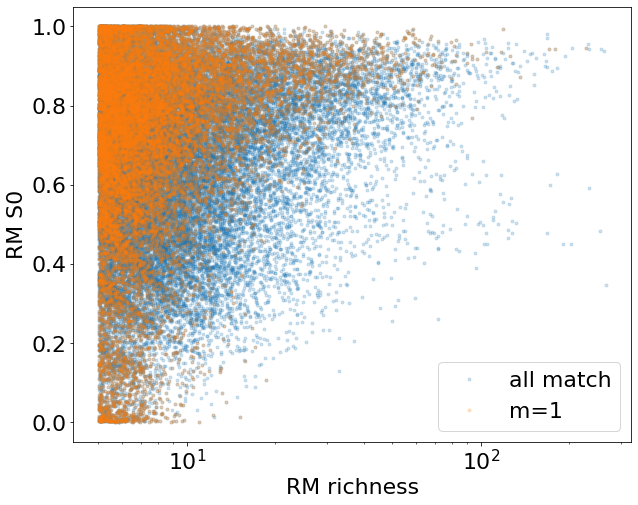

In [388]:
plt.plot(mt1['mass'], mt1["mt_frac_self"], '.', alpha=0.2, label ='all match')
plt.plot(mt1['mass'][multiplicity_RM_macth<2], mt1["mt_frac_self"][multiplicity_RM_macth<2], '.', alpha=0.2, label= 'm=1')

plt.xscale('log')

plt.xlabel('RM multiplicity')

plt.xlabel('RM richness')
plt.ylabel('RM S0')

plt.legend()

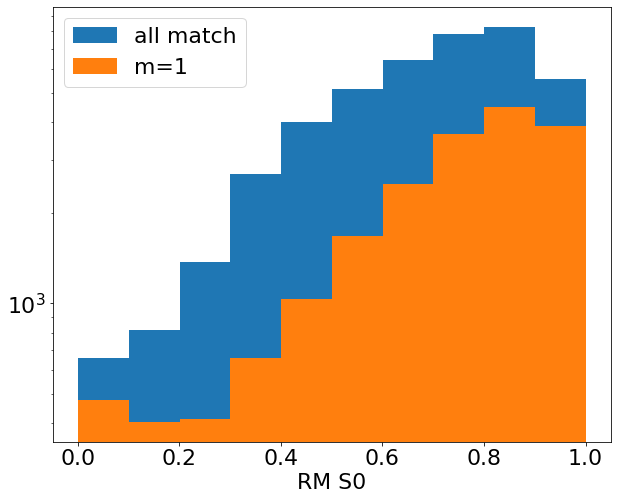

In [394]:
plt.hist(mt1["mt_frac_self"], label ='all match')
plt.hist(mt1["mt_frac_self"][multiplicity_RM_macth<2], label ='m=1')
plt.yscale('log')

plt.xlabel('RM S0')
plt.legend()

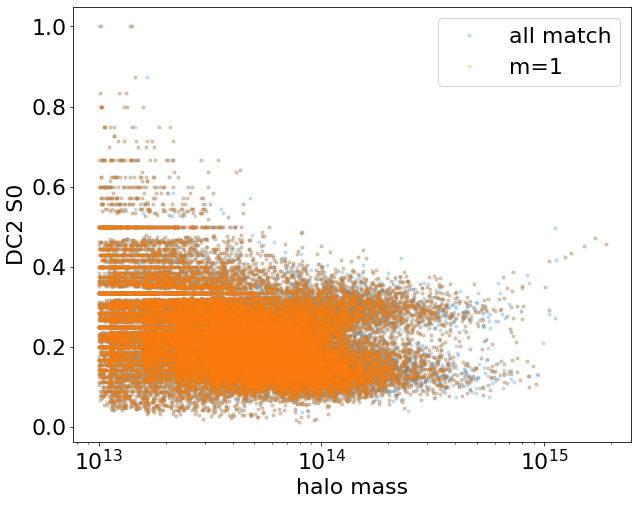

In [393]:
plt.plot(mt2['mass'], mt2["mt_frac_self"], '.', alpha=0.2, label ='all match')
plt.plot(mt2['mass'][multiplicity_DC2_macth<2], mt2["mt_frac_self"][multiplicity_DC2_macth<2], '.', alpha=0.2, label ='m=1')

plt.xscale('log')
plt.xlabel('halo mass')
plt.ylabel('DC2 S0')
plt.legend()

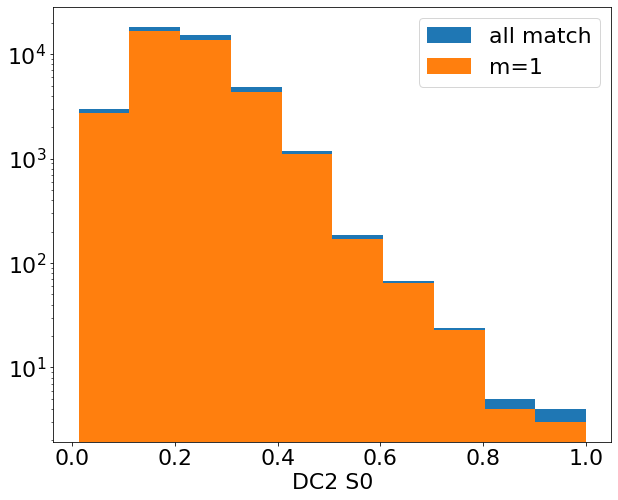

In [392]:
plt.hist(mt2["mt_frac_self"], label ='all match')
plt.hist(mt2["mt_frac_self"][multiplicity_DC2_macth<2], label ='m=1')
plt.yscale('log')

plt.xlabel('DC2 S0')
plt.legend()

# Completeness

In [397]:
def completeness_2d_clevar(halo_cat, mt2, bin_range = None, bins = None, nmin=10) :
    
    hist_num_match = np.histogram2d(mt2['z'], np.log10(mt2['mass']),range=bin_range, bins= bins)
    number_of_match = hist_num_match[0]
    
    hist_num_halo = np.histogram2d(halo_cat["z"],np.log10(halo_cat['mass']),range=bin_range, bins= bins)
    number_of_halo = hist_num_halo[0]
    
    #area_ratio = np.min([gc_truth.sky_area, gc.sky_area])/gc_truth.sky_area
    
    #compl_2d = 1/ area_ratio * number_of_match/number_of_halo
    compl_2d =  number_of_match/number_of_halo
    
    
    compl_2d_masked = np.ma.masked_where(number_of_halo<nmin, compl_2d)
    
    return compl_2d, compl_2d_masked

In [398]:
bin_range = [[0.1,1.4],[14.,14.8]]
bins = [13,8]

cond_mt = mt1["mass"]>20

compl_2d, compl_2d_mask = completeness_2d_clevar(halo_cat, mt2[cond_mt], bin_range = bin_range, bins = bins, nmin=10) 

<ipython-input-397-90b9ebc6f56f>:12: RuntimeWarning: invalid value encountered in true_divide
  compl_2d =  number_of_match/number_of_halo


Text(0.5, 1.0, 'completeness $\\lambda>20$')

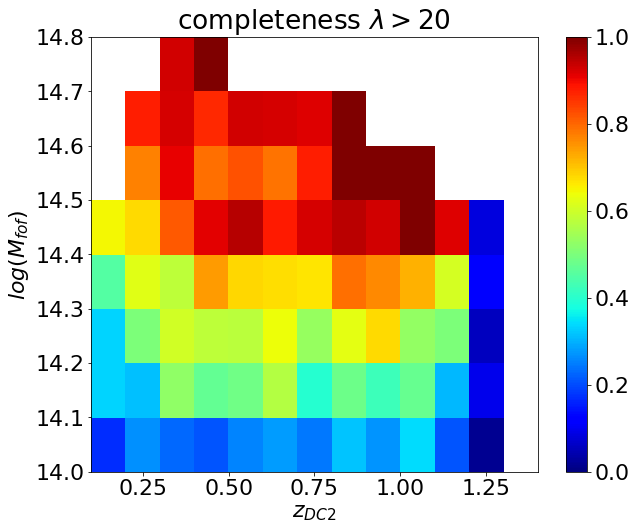

In [399]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(compl_2d_mask.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');
fig.colorbar(im , ax=ax);

ax.set_xlabel('$z_{DC2}$')
ax.set_ylabel('$log(M_{fof})$')

ax.set_title('completeness $\\lambda>20$')

In [400]:
bin_range = [[0.1,1.3],[13.,14.8]]
bins = [12,18]

cond_mt = mt1["mass"]>20

compl_2d, compl_2d_mask = completeness_2d_clevar(halo_cat, mt2[cond_mt], bin_range = bin_range, bins = bins, nmin=10) 

<ipython-input-397-90b9ebc6f56f>:12: RuntimeWarning: invalid value encountered in true_divide
  compl_2d =  number_of_match/number_of_halo


Text(0.5, 1.0, 'completeness $\\lambda>20$')

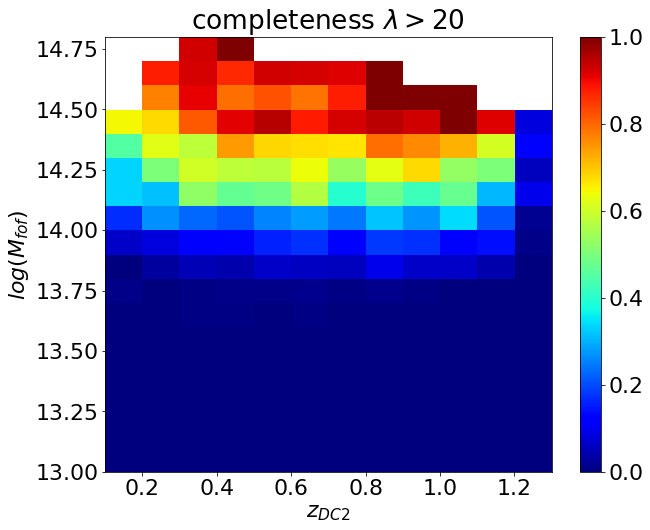

In [401]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(compl_2d_mask.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');
fig.colorbar(im , ax=ax);

ax.set_xlabel('$z_{DC2}$')
ax.set_ylabel('$log(M_{fof})$')

ax.set_title('completeness $\\lambda>20$')

In [402]:
bin_range = [[0.1,1.3],[13.,14.8]]
bins = [12,18]

cond_mt = mt1["mass"]>10

compl_2d, compl_2d_mask = completeness_2d_clevar(halo_cat, mt2[cond_mt], bin_range = bin_range, bins = bins, nmin=10) 

<ipython-input-397-90b9ebc6f56f>:12: RuntimeWarning: invalid value encountered in true_divide
  compl_2d =  number_of_match/number_of_halo


Text(0.5, 1.0, 'completeness $\\lambda>10$')

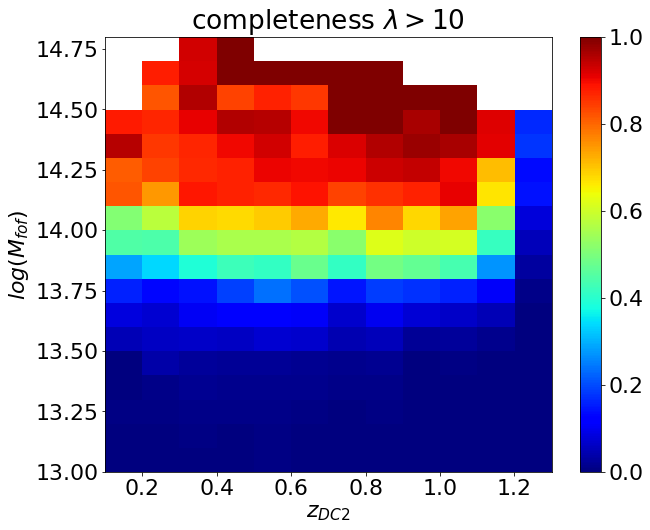

In [403]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(compl_2d_mask.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');
fig.colorbar(im , ax=ax);

ax.set_xlabel('$z_{DC2}$')
ax.set_ylabel('$log(M_{fof})$')

ax.set_title('completeness $\\lambda>10$')

In [404]:
bin_range = [[0.1,1.3],[13.,14.8]]
bins = [12,18]

#cond_mt = mt1["mass"]>20

compl_2d, compl_2d_mask = completeness_2d_clevar(halo_cat, mt2, bin_range = bin_range, bins = bins, nmin=10) 

<ipython-input-397-90b9ebc6f56f>:12: RuntimeWarning: invalid value encountered in true_divide
  compl_2d =  number_of_match/number_of_halo


Text(0.5, 1.0, 'completeness $\\lambda>5$')

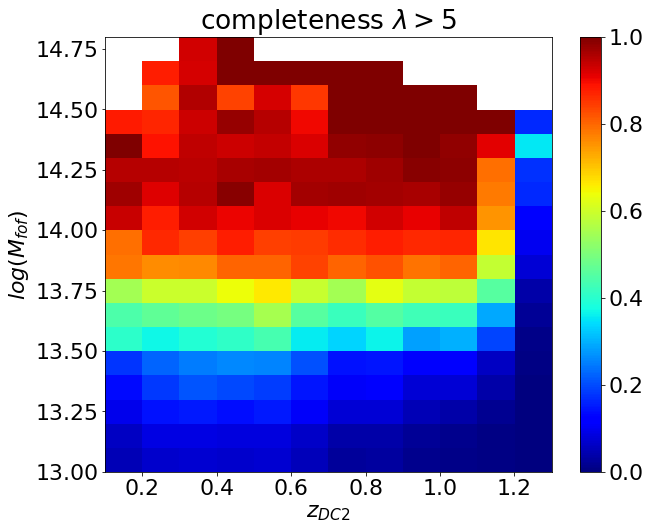

In [405]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(compl_2d_mask.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');
fig.colorbar(im , ax=ax);

ax.set_xlabel('$z_{DC2}$')
ax.set_ylabel('$log(M_{fof})$')

ax.set_title('completeness $\\lambda>5$')

# Purity

In [406]:
def purity_2d_clevar(RM_cat, mt1, bin_range = None, bins = None, nmin=10) :
    
    hist_num_match = np.histogram2d(mt1['z'],np.log10(mt1['mass']),range=bin_range, bins= bins)
    number_of_match = hist_num_match[0]
    
    hist_num_halo = np.histogram2d(RM_cat['z'], np.log10(RM_cat['mass']),range=bin_range, bins= bins)
    number_of_detection = hist_num_halo[0]
    
    #area_ratio = np.min([gc_truth.sky_area, gc.sky_area])/gc.sky_area
    
    #pure_2d = 1/ area_ratio * number_of_match/number_of_detection
    pure_2d = number_of_match/number_of_detection
    
    pure_2d_masked = np.ma.masked_where(number_of_detection<nmin, pure_2d)
    
    return pure_2d, pure_2d_masked


In [417]:
bin_range = [[0,1.2],[1.3,2.5]]
bins = [9,9]

cond_mt = mt2["mass"]>1e14

pure_2d, pure_2d_mask = purity_2d_clevar(RM_cat, mt1[cond_mt], bin_range = bin_range, bins = bins, nmin=10) 

<ipython-input-406-8529a8752da0>:12: RuntimeWarning: invalid value encountered in true_divide
  pure_2d = number_of_match/number_of_detection


Text(0.5, 1.0, 'purity $M_{FoF}>1e14 M_{\\odot}$')

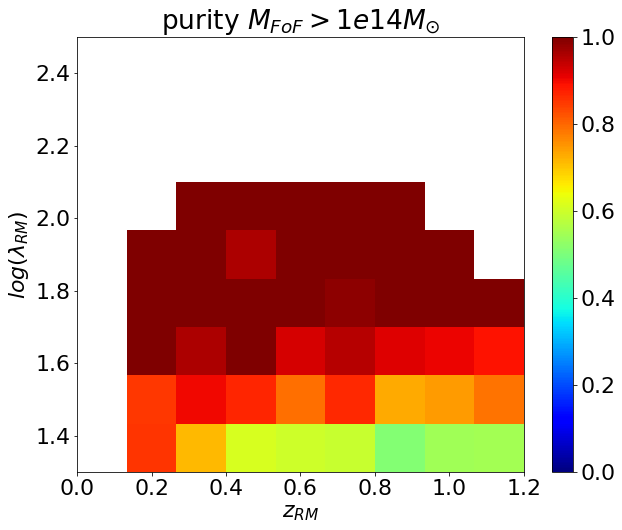

In [418]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(pure_2d_mask.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');
fig.colorbar(im , ax=ax);

ax.set_xlabel('$z_{RM}$')
ax.set_ylabel('$log(\lambda_{RM})$')

ax.set_title('purity $M_{FoF}>1e14 M_{\odot}$')

In [419]:
bin_range = [[0.,1.2],[0.7,2.2]]
bins = [12,15]

cond_mt = mt2["mass"]>1e14

pure_2d, pure_2d_mask = purity_2d_clevar(RM_cat, mt1[cond_mt], bin_range = bin_range, bins = bins, nmin=10) 

<ipython-input-406-8529a8752da0>:12: RuntimeWarning: invalid value encountered in true_divide
  pure_2d = number_of_match/number_of_detection


Text(0.5, 1.0, 'purity $M_{FoF}>1e14 M_{\\odot}$')

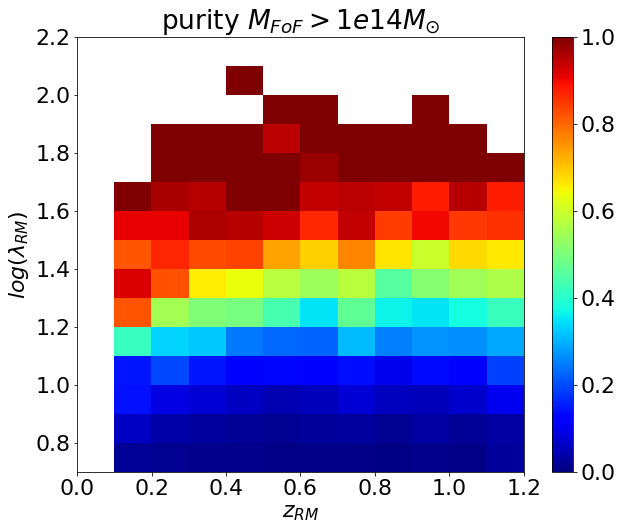

In [420]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(pure_2d_mask.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');
fig.colorbar(im , ax=ax);

ax.set_xlabel('$z_{RM}$')
ax.set_ylabel('$log(\lambda_{RM})$')

ax.set_title('purity $M_{FoF}>1e14 M_{\odot}$')

In [421]:
bin_range = [[0.,1.2],[0.7,2.2]]
bins = [12,15]

cond_mt = mt2["mass"]>5e13

pure_2d, pure_2d_mask = purity_2d_clevar(RM_cat, mt1[cond_mt], bin_range = bin_range, bins = bins, nmin=10) 

<ipython-input-406-8529a8752da0>:12: RuntimeWarning: invalid value encountered in true_divide
  pure_2d = number_of_match/number_of_detection


Text(0.5, 1.0, 'purity $M_{FoF}>5e13 M_{\\odot}$')

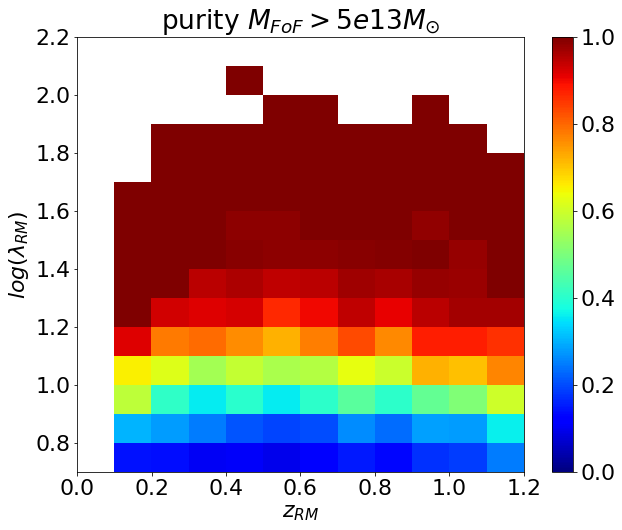

In [422]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(pure_2d_mask.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');
fig.colorbar(im , ax=ax);

ax.set_xlabel('$z_{RM}$')
ax.set_ylabel('$log(\lambda_{RM})$')

ax.set_title('purity $M_{FoF}>5e13 M_{\odot}$')

In [423]:
bin_range = [[0.,1.2],[0.7,2.2]]
bins = [12,15]

pure_2d, pure_2d_mask = purity_2d_clevar(RM_cat, mt1, bin_range = bin_range, bins = bins, nmin=10) 

<ipython-input-406-8529a8752da0>:12: RuntimeWarning: invalid value encountered in true_divide
  pure_2d = number_of_match/number_of_detection


Text(0.5, 1.0, 'purity $M_{FoF}>1e13 M_{\\odot}$')

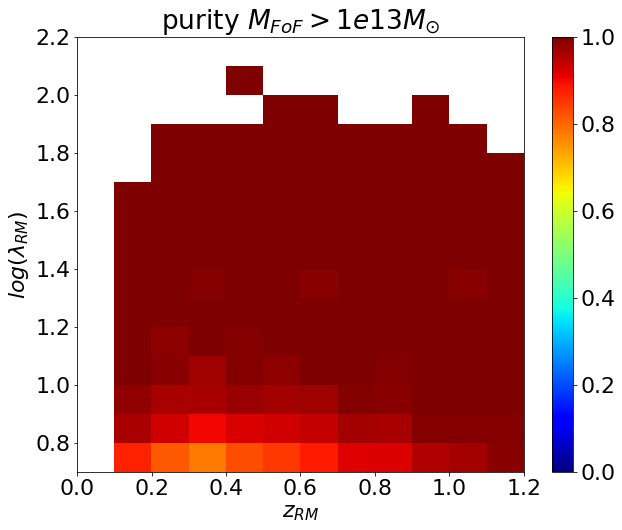

In [424]:
fig, ax = plt.subplots(1,1)

im = ax.imshow(pure_2d_mask.T,origin = 'lower',aspect='auto',extent = [bin_range[0][0],bin_range[0][1],bin_range[1][0],bin_range[1][1]],vmin=0,vmax=1,cmap='jet');
fig.colorbar(im , ax=ax);

ax.set_xlabel('$z_{RM}$')
ax.set_ylabel('$log(\lambda_{RM})$')

ax.set_title('purity $M_{FoF}>1e13 M_{\odot}$')

# Redshift recovery

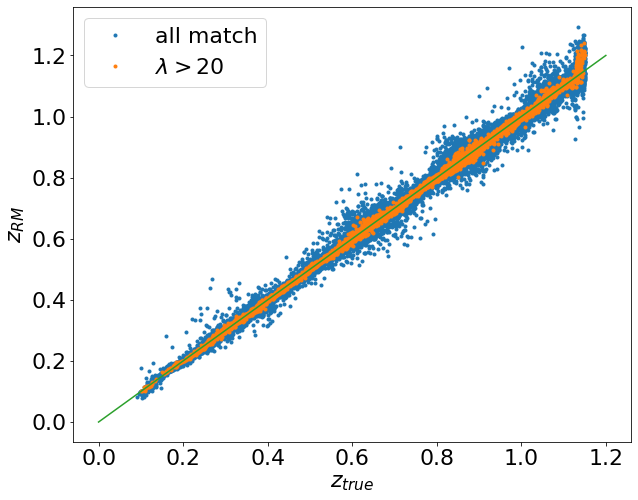

In [432]:
cond_mt = mt1["mass"]>20

plt.plot(mt1['z'], mt2['z'],'.',  label='all match')#/(1+halo_data['redshift'][ind_bij[:,1]]),bins=100,density=True);
plt.plot(mt1['z'][cond_mt], mt2['z'][cond_mt],'.',   label='$\lambda>20$');
plt.ylabel('$z_{RM}$')
plt.xlabel('$z_{true}$')

plt.plot((0.,1.2),(0.,1.2))

plt.legend()

# Center offset 

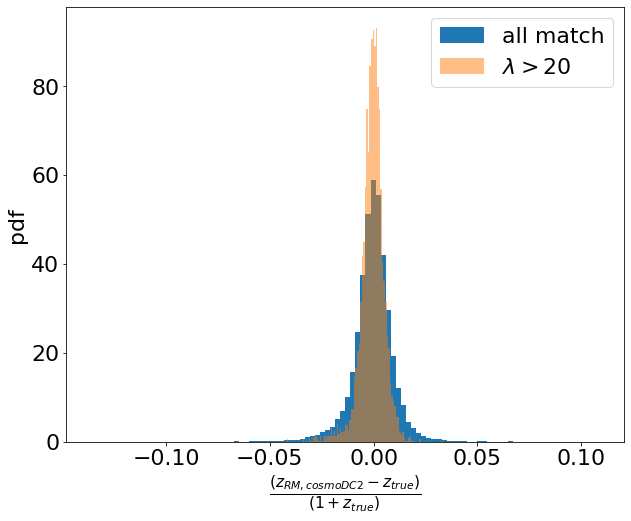

In [435]:
plt.hist((mt1['z']- mt2['z'])/(1+mt2['z']),bins=100,density=True, label='all match');
plt.hist((mt1['z'][cond_mt]- mt2['z'][cond_mt])/(1+mt2['z'][cond_mt]),bins=100,density=True,alpha=0.5, label='$\lambda>20$');

plt.xlabel('$\\frac{(z_{RM,cosmoDC2}-z_{true})}{(1+z_{true})}$')
plt.ylabel('pdf')

plt.legend()

In [213]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [214]:
coo_DC2_central = SkyCoord(mt2['ra']*u.deg, mt2['dec']*u.deg)
coo_RM_centrals = SkyCoord(mt1['ra']*u.deg, mt1['dec']*u.deg)

In [215]:
radial_offset =  coo_DC2_central.separation(coo_RM_centrals)
RM_and_DC2_centrals_offset_ang = radial_offset.arcmin

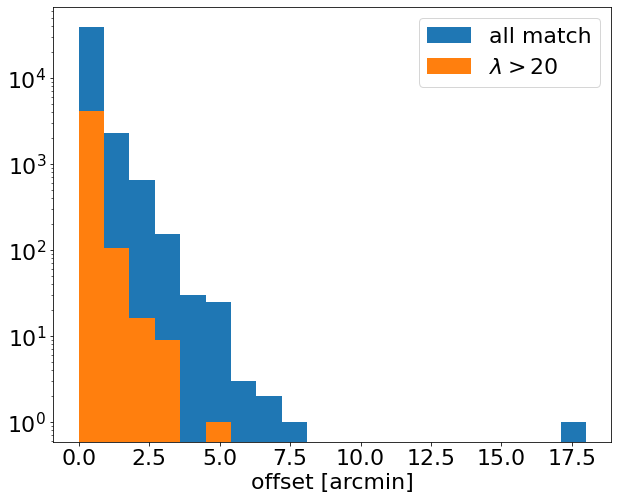

In [428]:
#RM to DC2 centrals position offset

cond_mt = mt1["mass"]>20

t_range = [0, np.ceil(np.max(RM_and_DC2_centrals_offset_ang))]

plt.hist(RM_and_DC2_centrals_offset_ang, bins=20, range=t_range, label='all match');
plt.hist(RM_and_DC2_centrals_offset_ang[cond_mt], bins=20, range=t_range,  label='$\lambda>20$');

plt.xlabel('offset [arcmin]')
plt.yscale('log')

plt.legend()

Text(0, 0.5, 'offset [arcmin]')

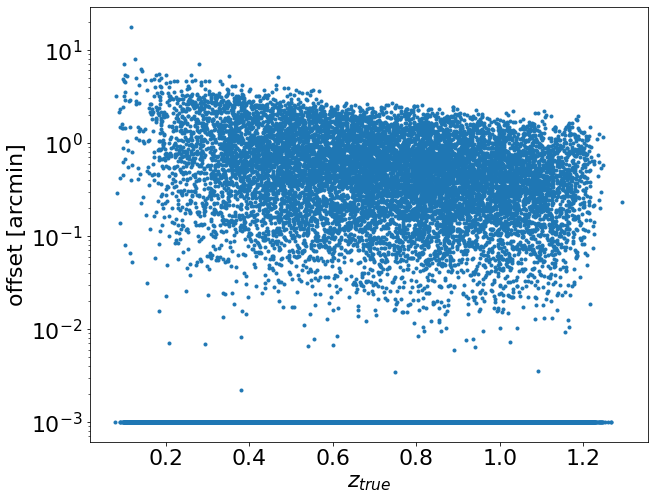

In [438]:
plt.plot(mt2['z'], RM_and_DC2_centrals_offset_ang+1e-3, '.')
plt.yscale('log')

plt.xlabel('$z_{true}$')
plt.ylabel('offset [arcmin]')

Text(0, 0.5, 'offset [arcmin]')

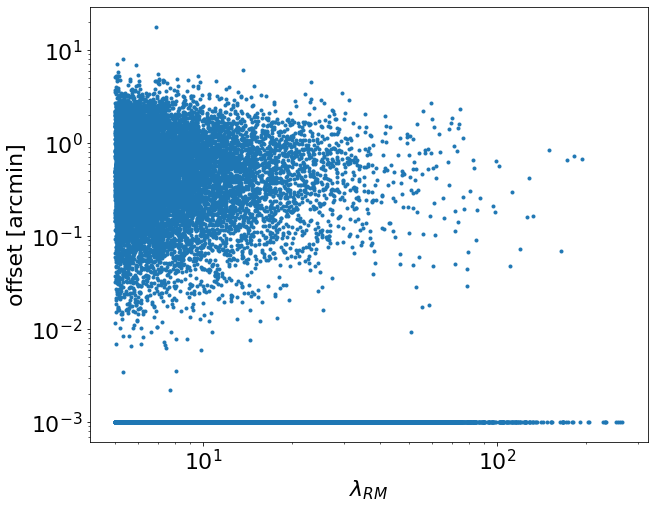

In [439]:
plt.plot(mt1['mass'], RM_and_DC2_centrals_offset_ang+1e-3, '.')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('$\\lambda_{RM}$')
plt.ylabel('offset [arcmin]')